In [1]:
import argparse
import os
import numpy as np
import math
import itertools
import time
import datetime
import sys

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

from pix2pix_models import *

import torch.nn as nn
import torch.nn.functional as F
import torch

import matplotlib.pyplot as plt
 
import glob

import pandas as pd
from skimage.metrics import structural_similarity as ssim


In [2]:
def test():
    x = torch.randn((1, 1, 256//2, 256//2))
    y = torch.randn((1, 1, 256//2, 256//2))
    model = Discriminator(in_channels=1)
    preds = model(x, y)
    #print(model)
    print(preds.shape)


if __name__ == "__main__":
    test()

torch.Size([1, 1, 30, 30])


In [3]:
parser = argparse.ArgumentParser()

parser.add_argument('-f')

parser.add_argument("--epoch", type=int, default=0, help="epoch to start training from")
parser.add_argument("--n_epochs", type=int, default=30, help="number of epochs of training")
parser.add_argument("--dataset_name", type=str, default="facades", help="name of the dataset")
parser.add_argument("--batch_size", type=int, default=50, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.0001, help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--decay_epoch", type=int, default=100, help="epoch from which to start lr decay")
parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
parser.add_argument("--img_height", type=int, default=256, help="size of image height")
parser.add_argument("--img_width", type=int, default=256, help="size of image width")
parser.add_argument("--channels", type=int, default=1, help="number of image channels")
parser.add_argument(
    "--sample_interval", type=int, default=500, help="interval between sampling of images from generators"
)
parser.add_argument("--checkpoint_interval", type=int, default=-1, help="interval between model checkpoints")
opt = parser.parse_args()
print(opt)

Namespace(f='/home/rdey/.local/share/jupyter/runtime/kernel-7e043a60-e1ab-48df-bf7d-a5c48bdffba2.json', epoch=0, n_epochs=30, dataset_name='facades', batch_size=50, lr=0.0001, b1=0.5, b2=0.999, decay_epoch=100, n_cpu=8, img_height=256, img_width=256, channels=1, sample_interval=500, checkpoint_interval=-1)


In [4]:
cuda = True if torch.cuda.is_available() else False

# Loss functions
criterion_GAN = torch.nn.MSELoss()
criterion_pixelwise = torch.nn.L1Loss()

# Loss weight of L1 pixel-wise loss between translated image and real image
lambda_pixel = 100

# Calculate output of image discriminator (PatchGAN)
patch = (1, opt.img_height // 2 ** 4, opt.img_width // 2 ** 4)



In [5]:
# Initialize generator and discriminator
generator = GeneratorUNet_attn(in_channels=1, out_channels=1)
discriminator = Discriminator(in_channels=1)

if cuda:
    generator = generator.cuda()
    discriminator = discriminator.cuda()
    criterion_GAN.cuda()
    criterion_pixelwise.cuda()

In [6]:
if opt.epoch != 0:
    # Load pretrained models
    generator.load_state_dict(torch.load("saved_models/%s/generator_%d.pth" % (opt.dataset_name, opt.epoch)))
    discriminator.load_state_dict(torch.load("saved_models/%s/discriminator_%d.pth" % (opt.dataset_name, opt.epoch)))
else:
    # Initialize weights
    generator.apply(weights_init_normal)
    discriminator.apply(weights_init_normal)

In [7]:
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))


Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor


# Load Data

In [8]:
## Filepath as DF


files_event = sorted(glob.glob('/home/rdey/scratch/waveforms/spect_event/*.pt',  
                   recursive = True) )

files_wave = sorted(glob.glob('/home/rdey/scratch/waveforms/spect_wave/*.pt',  
                   recursive = True) )


dict = {'event': files_event, 'wave': files_wave} 

df = pd.DataFrame(dict)

In [9]:
class CustomDataset(torch.utils.data.Dataset):
    
    def __init__(self,dataframe,transform = None):
        self.df = dataframe
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        filename = self.df["event"].iloc[index]
        target_filename = self.df["wave"].iloc[index]
        
        input_event = torch.load(filename, map_location=torch.device('cuda'))
        target_wave = torch.load(target_filename, map_location=torch.device('cuda'))
        
        if self.transform:
            input_event=self.transform(input_event.unsqueeze(0))
            target_wave=self.transform(target_wave.unsqueeze(0))
            
        return input_event,target_wave



In [10]:


# Configure dataloaders
transforms_ = transforms.Compose([
    transforms.Resize((opt.img_height, opt.img_width))])

params = {'batch_size':opt.batch_size ,
          'shuffle': False}

training_set=CustomDataset(df,transform= transforms_) #df[:100] for smaller dataset
training_generator = torch.utils.data.DataLoader(training_set,**params)


In [11]:
teste,testw=training_set.__getitem__(99)

/home/rdey/GW_ENV/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [12]:
transform2=transforms.Resize((256,256))
w=transforms_(testw.unsqueeze(0))


# Train model

In [13]:
# ----------
#  Training
# ----------

prev_time = time.time()

for epoch in range(opt.epoch, opt.n_epochs):
    for i, (imgs, target) in enumerate(training_generator):



        # Adversarial ground truths
        #valid = Variable(Tensor(np.ones((imgs.size(0), *patch))), requires_grad=False)
        #fake = Variable(Tensor(np.zeros((imgs.size(0), *patch))), requires_grad=False)
        
        

        # ------------------
        #  Train Generators
        # ------------------

        optimizer_G.zero_grad()

        # GAN loss
        fake_B = generator(imgs)
        pred_fake = discriminator(fake_B, imgs)
        
        # Adversarial ground truths        
        valid=torch.ones_like(pred_fake)
        fake=torch.zeros_like(pred_fake)
        
        
        loss_GAN = criterion_GAN(pred_fake, valid)
        # Pixel-wise loss
        loss_pixel = criterion_pixelwise(fake_B, target)

        # Total loss
        loss_G = loss_GAN + lambda_pixel * loss_pixel

        loss_G.backward()

        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Real loss
        pred_real = discriminator(target, imgs)

        loss_real = criterion_GAN(pred_real, valid)

        # Fake loss
        pred_fake = discriminator(fake_B.detach(), imgs)
        loss_fake = criterion_GAN(pred_fake, fake)

        # Total loss
        loss_D = 0.5 * (loss_real + loss_fake)

        loss_D.backward()
        optimizer_D.step()
        
    print(
            "[Epoch %d/%d]  [D loss: %f] [G loss: %f]"
            % (epoch,opt.n_epochs, loss_D.item(), loss_G.item())
             )


#         # --------------
#         #  Log Progress
#         # --------------

#         # Determine approximate time left
#         batches_done = epoch * len(dataloader) + i
#         batches_left = opt.n_epochs * len(dataloader) - batches_done
#         time_left = datetime.timedelta(seconds=batches_left * (time.time() - prev_time))
#         prev_time = time.time()

#         # Print log
#         sys.stdout.write(
#             "\r[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f, pixel: %f, adv: %f] ETA: %s"
#             % (
#                 epoch,
#                 opt.n_epochs,
#                 i,
#                 len(dataloader),
#                 loss_D.item(),
#                 loss_G.item(),
#                 loss_pixel.item(),
#                 loss_GAN.item(),
#                 time_left,
#             )
#         )

#         # If at sample interval save image
#         if batches_done % opt.sample_interval == 0:
#             sample_images(batches_done)

#     if opt.checkpoint_interval != -1 and epoch % opt.checkpoint_interval == 0:
#         # Save model checkpoints
#         torch.save(generator.state_dict(), "saved_models/%s/generator_%d.pth" % (opt.dataset_name, epoch))
#         torch.save(discriminator.state_dict(), "saved_models/%s/discriminator_%d.pth" % (opt.dataset_name, epoch))

[Epoch 0/30]  [D loss: 0.190755] [G loss: 33.556938]
[Epoch 1/30]  [D loss: 0.100768] [G loss: 31.047245]
[Epoch 2/30]  [D loss: 0.241716] [G loss: 29.940462]
[Epoch 3/30]  [D loss: 0.049048] [G loss: 28.851307]
[Epoch 4/30]  [D loss: 0.040350] [G loss: 28.337307]
[Epoch 5/30]  [D loss: 0.031671] [G loss: 28.063662]
[Epoch 6/30]  [D loss: 0.066331] [G loss: 27.887915]
[Epoch 7/30]  [D loss: 0.055845] [G loss: 27.527182]
[Epoch 8/30]  [D loss: 0.037994] [G loss: 27.168133]
[Epoch 9/30]  [D loss: 0.023449] [G loss: 27.056496]
[Epoch 10/30]  [D loss: 0.030194] [G loss: 26.954199]
[Epoch 11/30]  [D loss: 0.048406] [G loss: 26.737450]
[Epoch 12/30]  [D loss: 0.025547] [G loss: 26.613840]
[Epoch 13/30]  [D loss: 0.025601] [G loss: 26.500517]
[Epoch 14/30]  [D loss: 0.017345] [G loss: 26.521597]
[Epoch 15/30]  [D loss: 0.082708] [G loss: 26.506565]
[Epoch 16/30]  [D loss: 0.012718] [G loss: 26.300184]
[Epoch 17/30]  [D loss: 0.013634] [G loss: 26.266403]
[Epoch 18/30]  [D loss: 0.054918] [G l

# Test

In [14]:
teste,testw=training_set.__getitem__(10)





test_img=transforms_(teste.unsqueeze(0))
test_img_plot=test_img.squeeze().detach().cpu()


test_target=transforms_(testw.unsqueeze(0))
test_target=test_target.squeeze().detach().cpu()

DN_test=generator(test_img)
DN_test_=DN_test.squeeze().detach().cpu()

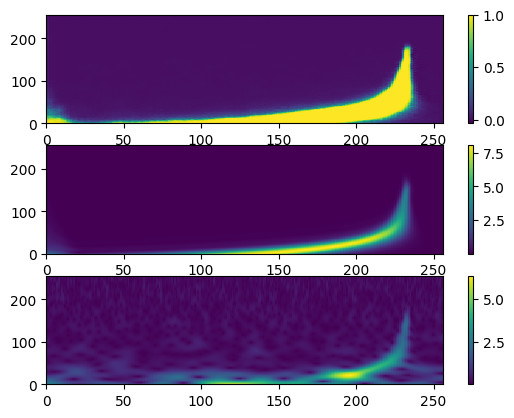

In [15]:
fig, axs = plt.subplots(3)

a0=axs[0].pcolor(DN_test_)
a1=axs[1].pcolor(test_target)
a2=axs[2].pcolor(test_img_plot)
fig.colorbar(a0)
fig.colorbar(a1)
fig.colorbar(a2)

## PSNR and SSIM

In [2]:
from math import log10, sqrt 
import cv2 
import numpy as np 
  
def PSNR(original, compressed): 
    mse = np.mean((original - compressed) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr 
  
def main(): 
     original = cv2.imread("original_image.png") 
     compressed = cv2.imread("compressed_image.png", 1) 
     value = PSNR(original, compressed) 
     print(f"PSNR value is {value} dB") 
       
# if __name__ == "__main__": 
#     main()

In [ ]:
type(test_target)

In [ ]:
(score, diff) = ssim(DN_test_.numpy(), test_target.numpy(), full=True,data_range=1)
score

In [ ]:
plt.pcolor(diff)
plt.colorbar()